# 2024 CITS4012 Project

# Readme

# 1. Dataset Processing

## Importing Libraries

In [8]:
import re
import json
import time
import math
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Loading Datasets

In [9]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [40]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cpu


In [10]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist()
training_a = train_data['aspect'].tolist()
training_y = train_data['polarity'].tolist()
val_x = val_data['sentence'].tolist()
val_a = val_data['aspect'].tolist()
val_y = val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [11]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Polarity Distribution
polarity_distribution = train_data['polarity'].value_counts()
print("\nPolarity Distribution:")
print(polarity_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7090
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Polarity Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)          

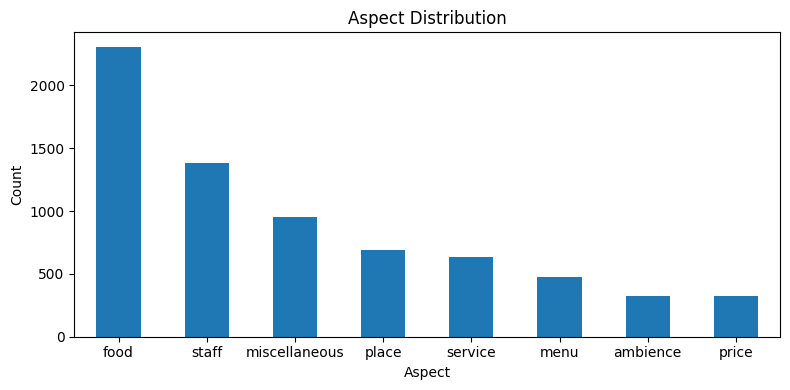

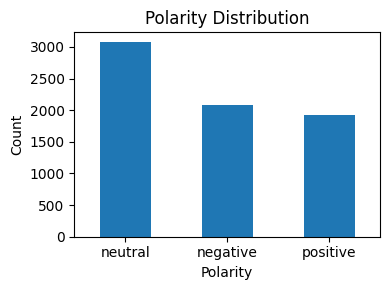

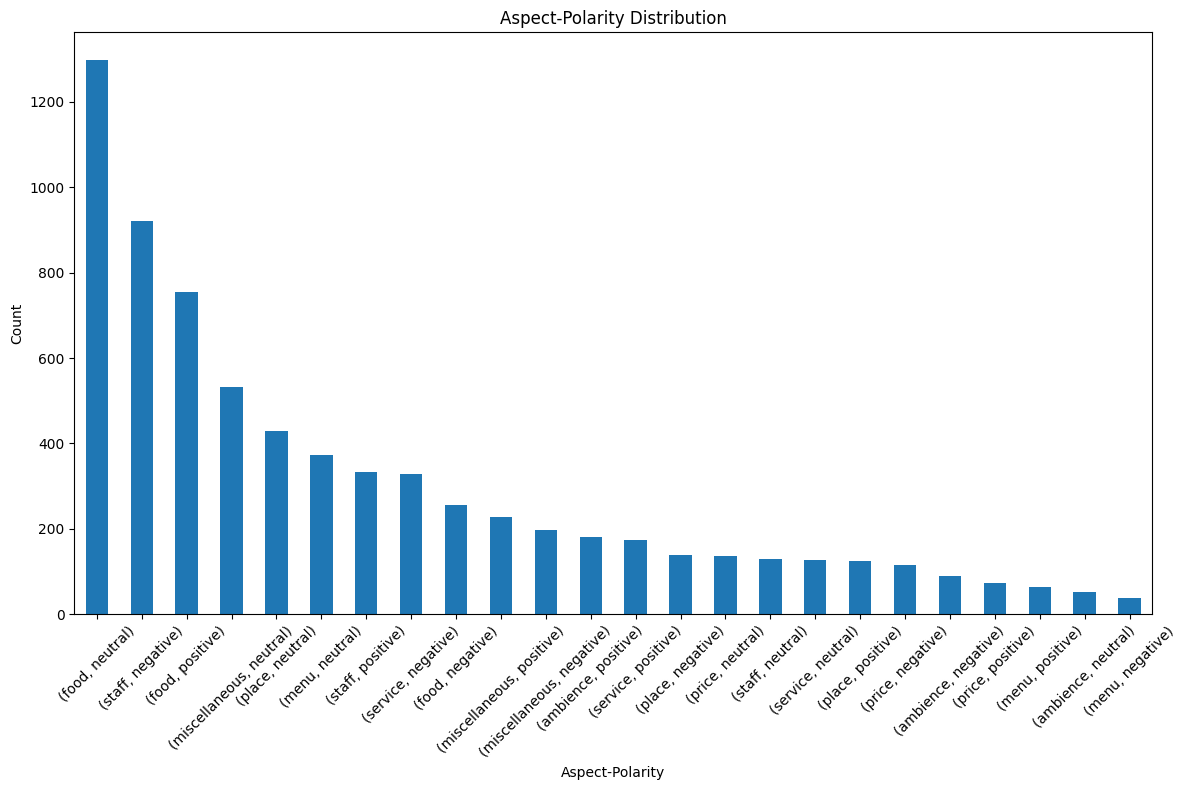

In [12]:
# Function to plot distribution bar graphs
def plot_distribution(figsize, distribution, title, xlabel, rotation=0):
    plt.figure(figsize=figsize)
    distribution.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# Plot Aspect Distribution
plot_distribution((8, 4), aspect_distribution, 'Aspect Distribution', 'Aspect')
# Plot Polarity Distribution
plot_distribution((4, 3), polarity_distribution, 'Polarity Distribution', 'Polarity')
# Plot Aspect-Polarity Distribution
plot_distribution((12, 8), aspect_polarity_freq, 'Aspect-Polarity Distribution', 'Aspect-Polarity', 45)

## Data Preprocessing

In [13]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 660.6 kB/s eta 0:00:20
     ---------------------------------------- 0.1/12.8 MB 1.4 MB/s eta 0:00:09
      --------------------------------------- 0.3/12.8 MB 2.1 MB/s eta 0:00:06
     - -------------------------------------- 0.4/12.8 MB 2.3 MB/s eta 0:00:06
     - -------------------------------------- 0.6/12.8 MB 2.6 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/12.8 MB 2.7 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 2.7 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 2.7 MB/s eta 0:00:05
     --- ------------------------------------ 1.1/12.8 MB 2.8 MB/s eta 0:00:05
     --- ------------------------------------ 1.3/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.4/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.6/12.8 MB 

In [14]:
# Spacy
nlp = spacy.load("en_core_web_sm")

# Remove certain words from the stop words list
custom_stop_words = [
    "not", "no", "never", "neither", "nor",
    "nobody", "nothing", "nowhere", "none", "cannot", 
    "but"
]

for a in custom_stop_words:
    nlp.vocab[a].is_stop = False

# Perform Stopwords Removal, Lemmatisation and Tokenisation
def spacy_processing(x):
    doc = nlp(x)
    x = [word.lemma_ for word in doc if not word.is_stop]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

In [15]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = re.sub(r'[^\w\s]', ' ', sentence)    # Remove punctuation
        sentence = re.sub(r"\s+", " ", sentence)        # Remove extra spaces
        tokens = spacy_processing(sentence)             # Remove stopwords / Lemmatisation / Tokenise
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)
val_x_token = preprocess_data(val_x)

## Create Word Vocabulary

In [16]:
# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<SEP>': 0}
review = train_x_token + test_x_token + val_x_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]
MAX_LENGTH = len(max(review, key=len)) # Maximum length of a sentence

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}

## Convert Words to Index form

In [17]:
# Function to convert list of tokens to list of indices
def list_to_index(token_list, word_to_idx):
    idx_list = []
    for tokens in token_list:
        idx_list.append([word_to_idx[token] for token in tokens])
    return idx_list

# Function to convert list of strings to list of indices
def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Token index lists for training data
train_x_idx = list_to_index(train_x_token, word_to_idx)
train_a_idx = string_to_index(training_a, word_to_idx)
train_y_idx = string_to_index(training_y, polarity_to_idx)

# Max length of the sentence after appending aspect
MAX_COMBINED_LENGTH = MAX_LENGTH + 1
MAX_REP_LENGTH = MAX_LENGTH*2
MAX_REPSEP_LENGTH = MAX_LENGTH*3

## Functions to Combine Aspect to Sentence for Input Data

In [18]:
# Append aspect to the end of the sentence
def combine_sentence_aspect(sentence, aspect, has_sep):
    if has_sep:
        sep_idx = word_to_idx['<SEP>']
        combined_idx = sentence + [sep_idx] + [aspect]
    else:
        combined_idx = sentence + [aspect]
    return combined_idx

# Append aspect after every word
def combine_repeat_aspect(sentence, aspect, has_sep):
    combined_idx = []
    for word in sentence:
        if has_sep:
            sep_idx = word_to_idx['<SEP>']
            combined_idx = combined_idx + [word] + [sep_idx] + [aspect]
        else:
            combined_idx = combined_idx + [word] + [aspect]
    return combined_idx

## Pretrained Word Embeddings from Glove

In [20]:
# Get Weights for the Embedding Layer (GloVe)
embedding_size = 100
glove_model = api.load("glove-twitter-100")
glove_weights = np.zeros((vocab_size, embedding_size))
for i, word in enumerate(word_to_idx.keys()):
    try:
        # If word in glove, get the weights
        glove_weights[i] = glove_model[word]
    except:
        # If word not in glove, initialise with random weights
        glove_weights[i] = np.random.uniform(low=-0.1, high=0.1, size=embedding_size)

# 2. Model Implementation

## Model Variants

In [21]:
# Different aspect integration
NO_ASPECT       = 'no aspect integration'
ASPECT_EMBED    = 'word embedding + aspect embedding'
WITH_SEP        = 'end of sentence with separator'
NO_SEP          = 'end of sentence no separator'
ASPECT_REP_SEP  = 'aspect repeat with separator'
ASPECT_REP      = 'aspect repeat no separator'

# Different attention mechanisms
ATTN_NONE       = 'no_attention'
ATTN_DOT        = 'dot_product'
ATTN_SCALE_DOT  = 'scaled_dot_product'
ATTN_COSINE     = 'cosine_similarity'

## Model Architecture

In [22]:
# LSTM Model
class Model(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, embedding, integration, attention='dot_product', num_layers=1):
        super(Model, self).__init__()
        self.integration_type = integration
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.linear_attention = nn.Linear(self.hidden_size*2, self.output_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    # Compute output with attention mechanism
    def attention(self, hidden, encoder_hiddens):
        if self.attention_type == ATTN_DOT:             # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == ATTN_SCALE_DOT:     # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == ATTN_COSINE:        # Cosine similarity attention
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        output = F.log_softmax(self.linear_attention(concat_output), dim=1)
        return output, attn_weights
    
    # Forward propagation   
    def forward(self, input, hidden, cell, encoder_hiddens, aspect, is_last):
        word_embedding = self.embedding(input).view(1, 1, -1)
        
        if self.integration_type in [WITH_SEP, NO_SEP, ASPECT_REP_SEP, ASPECT_REP, NO_ASPECT]:
            output, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
        elif self.integration_type == ASPECT_EMBED:
            aspect_embedding = self.embedding(aspect).view(1, 1, -1)
            embedded = torch.cat((aspect_embedding, word_embedding), 0)
            output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        attn_weights = None
        if is_last: # Attention Mechanism and generate output
            if self.attention_type == ATTN_NONE:
                output = F.log_softmax(self.linear(output[0]), dim=1)
            else:
                output, attn_weights = self.attention(hidden, encoder_hiddens)
        return output, (hidden, cell), attn_weights
    
    # Initialise hidden and cell states
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Helper Functions for Training
- asMinutes() : Convert time to minutes
- timeSince() : Calculate time since last checkpoint
- prepare_input_tensors(): Prepare input tensors for different integration types
- prepare_data() : Prepare tensor data for training
- feed_sequence() : Feed sequence word by word to model

In [23]:
# Function to get time elapsed during training
# Reference: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to prepare input tensors for different integration types
def prepare_input_tensors(sent_idx, asp_idx, combine_function):
    # Combine sentence and aspect
    combined = combine_function(sent_idx, asp_idx, has_sep=False)
    index = [[idx] for idx in combined]
    tensor = torch.LongTensor(index).to(device)
    # Combine sentence and aspect with separator
    combined_sep = combine_function(sent_idx, asp_idx, has_sep=True)
    sep_index = [[idx] for idx in combined_sep]
    sep_tensor = torch.LongTensor(sep_index).to(device)
    return tensor, sep_tensor

# Function to prepare data for training
def prepare_data(random_idx):
    # Input data - sentence
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    x_tensor = torch.LongTensor(x_index).to(device)
    # Input data - aspect
    a_index = train_a_idx[random_idx]
    a_tensor = torch.LongTensor([a_index]).to(device)
    # Input data - aspect integrated
    x_temp = train_x_idx[random_idx]
    xa_tensor, xa_sep_tensor = prepare_input_tensors(x_temp, a_index, combine_sentence_aspect)
    xar_tensor, xar_sep_tensor = prepare_input_tensors(x_temp, a_index, combine_repeat_aspect)
    # Target data
    y_index = train_y_idx[random_idx]
    y_tensor = torch.LongTensor([y_index]).to(device)
    return x_tensor, a_tensor, xa_tensor, xa_sep_tensor, xar_tensor, xar_sep_tensor, y_tensor

# Function to feed input tensor during training
def feed_sequence(model, input_tensor, aspect_tensor, max_length):
    hiddens = torch.zeros(max_length, model.hidden_size, device=device)  # For attention mechanism
    hidden = model.init_hidden()                          # Hidden state
    cell = model.init_hidden()                            # Cell state
    for i in range(input_tensor.size(0)):
        is_last = (i==input_tensor.size(0)-1)
        if is_last:
            y_output, (_, _), _ = model(input_tensor[i], hidden, cell, hiddens, aspect_tensor, is_last=is_last)
        else:
            _, (hidden, cell), _ = model(input_tensor[i], hidden, cell, hiddens, aspect_tensor, is_last=is_last)
            hiddens[i] = hidden[0, 0]    
    return y_output

## Function to Train Model
- train() : Train model on training data based on different integration types
- plot_graphs() : Plot average loss or accuracy graph over epochs
- Note: have to run the [Evaluation functions](#evaluation) for Accuracy graph visualisation 

In [33]:
# Function to train model
def train(embedding, attention_type, integration_type,
          num_epochs=10000, print_interval=500, plot_interval=200, 
          learning_rate=0.001, hidden_size=100, accuracy_graph=False):
    
    model = Model(hidden_size, 3, embedding, integration_type, attention_type, num_layers=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    plot_accuracy, plot_avg_losses, print_loss_total, plot_loss_total = [], [], 0, 0
    start = time.time()

    for epoch in range(1, num_epochs+1):
        random_idx = random.choice(range(len(train_data)))
        x_tensor, a_tensor, xa_tensor, xa_sep_tensor, xar_tensor, xar_sep_tensor, y_tensor = prepare_data(random_idx)

        loss = 0
        model.train()
        optimizer.zero_grad()
        
        # Feed the input tensor into the model
        if integration_type == NO_ASPECT:
            y_output = feed_sequence(model, x_tensor, a_tensor, MAX_LENGTH)
        elif integration_type == WITH_SEP:
            y_output = feed_sequence(model, xa_sep_tensor, a_tensor, MAX_COMBINED_LENGTH+1)
        elif integration_type == ASPECT_EMBED:
            y_output = feed_sequence(model, x_tensor, a_tensor, MAX_LENGTH)
        elif integration_type == NO_SEP:
            y_output = feed_sequence(model, xa_tensor, a_tensor, MAX_COMBINED_LENGTH)
        elif integration_type == ASPECT_REP_SEP:
            y_output = feed_sequence(model, xar_sep_tensor, a_tensor, MAX_REPSEP_LENGTH)
        elif integration_type == ASPECT_REP:
            y_output = feed_sequence(model, xar_tensor, a_tensor, MAX_REP_LENGTH)

        loss += criterion(y_output, y_tensor)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        print_loss_total += loss.item()
        plot_loss_total += loss.item()
        
        if epoch % print_interval == 0:
            print_avg_loss = print_loss_total / print_interval
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_loss_total = 0
            
        if epoch % plot_interval == 0:
            # Calculate average loss over plot interval
            plot_avg_loss = plot_loss_total / plot_interval
            plot_avg_losses.append(plot_avg_loss)
            plot_loss_total = 0
            
            # Calculate accuracy on validation set
            if accuracy_graph:
                accuracy = evaluate(model, val_x, val_a, val_y, integration_type, visualisation=False)
                plot_accuracy.append(accuracy)
            
    return model, plot_avg_losses, plot_accuracy

# Function to plot average loss or accuracy graph over epochs
def plot_graphs(num_epochs, interval, plot_data, title, metric):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs+1, interval), plot_data)
    plt.title(f'{metric.capitalize()} over Epochs ({title})')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()

## Selected Hyperparameters

In [25]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# # Get word embeddings
# embedding = nn.Embedding(vocab_size, hidden_size)
# embedding.weight.data.copy_(torch.from_numpy(glove_weights))
# print("Shape of the embedding weights:", embedding.weight.data.shape)

Shape of the embedding weights: torch.Size([5688, 100])


# 3. Testing and Evaluation

## Functions to Visualise Attention Weights
- plot_attention() : Plot attention weights for a given sentence

In [26]:
# Define custom colormap with Blue as highest values and white as lowest values
colors = [(1, 1, 1), (0.2, 0.4, 1)]  # White to Blue
cmap_name = 'custom_blue_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Function to plot attention weights for a sentence
def plot_attention(words, attention_weights, sentence, aspect, pred_polarity, true_polarity):
    # Create figure and axis
    size = len(words)
    fig, ax = plt.subplots(figsize=(size, 2)) 
    norm = plt.Normalize(vmin=0, vmax=0.1)  

    # Plot each word with attention weight as colored box
    for i, (word, weight) in enumerate(zip(words, attention_weights)):
        # Plot word
        ax.text(i, 0.5, word, ha='center', va='center', fontsize=12)

        # Plot colored box above word
        color = custom_cmap(norm(weight))
        rect = plt.Rectangle((i - 0.5, 0.6), 1, 0.4, color=color, ec='black')
        ax.add_patch(rect)

    # Set x-axis and y-axis properties
    ax.set_xlim(-0.5, size - 0.5)

    # Remove x-axis and y-axis lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Hide ticks on x-axis and y-axis
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title(f'Aspect: {aspect} | Predicted Polarity: {pred_polarity} | True Polarity: {true_polarity}', fontsize=14)

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    ax.text(-1, 0.2, sentence, ha='left', va='center', fontsize=12)
    fig.subplots_adjust(top=0.9, bottom=0.2, left=0.05, right=0.95)

    # Show plot
    plt.show()

## Function to Evaluate Model
- predict() : Predict polarity of a given sentence based on an aspect
- evaluate() : Evaluate model on val/test data and return accuracy
<a id="evaluation"></a>

In [34]:
# Function to get model's prediction on test data
def predict(model, sentence, aspect, integration_type):
    model.eval()
    with torch.no_grad():
        # Prepare input data for different integration types
        sent = preprocess_data([sentence])[0]
        sent_idx = [word_to_idx[word] for word in sent]
        aspect_idx = word_to_idx[aspect]
        no_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=False)
        with_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=True)
        rep_idx = combine_repeat_aspect(sent_idx, aspect_idx, has_sep=False)
        rep_sep_idx = combine_repeat_aspect(sent_idx, aspect_idx, has_sep=True)
        aspect_tensor = torch.LongTensor([[aspect_idx]]).to(device)
        
        # Prepare input tensor and initialise encoder hidden states for different integration types
        if integration_type == NO_ASPECT:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx]).to(device)
            encoder_hiddens = torch.zeros(MAX_LENGTH, model.hidden_size, device=device)
        elif integration_type == WITH_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in with_sep_idx]).to(device)
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH+1, model.hidden_size, device=device)
        elif integration_type == ASPECT_EMBED:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx]).to(device)
            encoder_hiddens = torch.zeros(MAX_LENGTH, model.hidden_size, device=device)
        elif integration_type == NO_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in no_sep_idx]).to(device)
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH, model.hidden_size, device=device)
        elif integration_type == ASPECT_REP_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in rep_sep_idx]).to(device)
            encoder_hiddens = torch.zeros(MAX_REPSEP_LENGTH, model.hidden_size, device=device)
        elif integration_type == ASPECT_REP:
            input_tensor = torch.LongTensor([[idx] for idx in rep_idx]).to(device)
            encoder_hiddens = torch.zeros(MAX_REP_LENGTH, model.hidden_size, device=device)
            
        attention_weights = []
        input_length = input_tensor.size(0)
        encoder_hidden = model.init_hidden()    # Initialise hidden states
        encoder_cell = model.init_hidden()      # Initialise cell states
        
        for ei in range(input_length):
            is_last = (ei==input_length-1)
            if is_last:
                y_output, (_, _), attn_weight  = model(input_tensor[ei], encoder_hidden, encoder_cell, encoder_hiddens, aspect_tensor, is_last=is_last)
                attention_weights.append(attn_weight)
            else:
                _, (encoder_hidden, encoder_cell), _ = model(input_tensor[ei], encoder_hidden, encoder_cell, encoder_hiddens, aspect_tensor, is_last=is_last)
                encoder_hiddens[ei] = encoder_hidden[0, 0]
            
        _, topi = y_output.topk(1)
        polarity = idx_to_polarity[topi[0].item()]
        return polarity, attention_weights, input_tensor

# Function to get words and their corresponding attention weights
def get_words_weights(input_words, attn_weights, integration_type):
    words = []
    weights = []
    for i, word in enumerate(input_words):
        if ((integration_type == ASPECT_REP and i % 2 == 0) or
            (integration_type == ASPECT_REP_SEP and i % 3 == 0) or
            (integration_type == WITH_SEP and i < len(input_words) - 2) or
            (integration_type == NO_SEP and i < len(input_words) - 1) or
            (integration_type == NO_ASPECT or integration_type == ASPECT_EMBED)):
            words.append(word)
            weights.append(attn_weights[i])
    return words, weights

# Function to calculate model accuracy on test data
def evaluate(model, data_x, data_a, data_y, integration_type):
    correct = 0
    for i in range(len(data_x)):
        sentence, aspect, polarity = data_x[i], data_a[i], data_y[i]
        pred_polarity, _, _ = predict(model, sentence, aspect, integration_type)
        # Check if prediction is correct
        if pred_polarity == polarity:
            correct += 1  
    accuracy = correct / len(test_data)
    return accuracy

## No Aspect

In [37]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = NO_ASPECT

embedding0 = nn.Embedding(vocab_size, hidden_size)
embedding0.weight.data.copy_(torch.from_numpy(glove_weights))

# Train the model
model0, plot_avg_losses0, plot_accuracy0 = train(embedding0, attention_type, integration_type, 
                                                 num_epochs=num_epochs, learning_rate=learning_rate, 
                                                 hidden_size=hidden_size, accuracy_graph=False)

# Get the accuracy of the model on test data
accuracy0 = evaluate(model0, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy0:.4f}")

0m 5s (- 1m 52s) Epoch [500/10000] Loss: 1.0673
0m 11s (- 1m 45s) Epoch [1000/10000] Loss: 1.0538
0m 17s (- 1m 39s) Epoch [1500/10000] Loss: 1.0370
0m 23s (- 1m 32s) Epoch [2000/10000] Loss: 1.0125
0m 29s (- 1m 28s) Epoch [2500/10000] Loss: 0.9916
0m 35s (- 1m 22s) Epoch [3000/10000] Loss: 0.9686
0m 41s (- 1m 16s) Epoch [3500/10000] Loss: 0.9438
0m 47s (- 1m 10s) Epoch [4000/10000] Loss: 0.9675
0m 53s (- 1m 5s) Epoch [4500/10000] Loss: 0.9302
0m 59s (- 0m 59s) Epoch [5000/10000] Loss: 0.9633
1m 5s (- 0m 53s) Epoch [5500/10000] Loss: 0.9561
1m 11s (- 0m 47s) Epoch [6000/10000] Loss: 0.9043
1m 17s (- 0m 41s) Epoch [6500/10000] Loss: 0.9080
1m 23s (- 0m 35s) Epoch [7000/10000] Loss: 0.9253
1m 30s (- 0m 30s) Epoch [7500/10000] Loss: 0.8683
1m 36s (- 0m 24s) Epoch [8000/10000] Loss: 0.9116
1m 42s (- 0m 18s) Epoch [8500/10000] Loss: 0.9160
1m 48s (- 0m 12s) Epoch [9000/10000] Loss: 0.8801
1m 55s (- 0m 6s) Epoch [9500/10000] Loss: 0.8559
2m 1s (- 0m 0s) Epoch [10000/10000] Loss: 0.8946
Accura

## Word Embedding + Aspect Embedding

In [36]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_EMBED

embedding1 = nn.Embedding(vocab_size, hidden_size)
embedding1.weight.data.copy_(torch.from_numpy(glove_weights))

# Train the model
model1, plot_avg_losses1, plot_accuracy1 = train(embedding1, attention_type, integration_type, 
                                                 num_epochs=num_epochs, learning_rate=learning_rate, 
                                                 hidden_size=hidden_size, accuracy_graph=False)

# Get the accuracy of the model on test data
accuracy1 = evaluate(model1, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy1:.4f}")

0m 7s (- 2m 14s) Epoch [500/10000] Loss: 0.9987
0m 14s (- 2m 8s) Epoch [1000/10000] Loss: 0.8975
0m 21s (- 2m 1s) Epoch [1500/10000] Loss: 0.9097
0m 28s (- 1m 54s) Epoch [2000/10000] Loss: 0.8673
0m 35s (- 1m 46s) Epoch [2500/10000] Loss: 0.8771
0m 42s (- 1m 39s) Epoch [3000/10000] Loss: 0.8209
0m 49s (- 1m 31s) Epoch [3500/10000] Loss: 0.8576
0m 56s (- 1m 24s) Epoch [4000/10000] Loss: 0.8111
1m 2s (- 1m 16s) Epoch [4500/10000] Loss: 0.8386
1m 9s (- 1m 9s) Epoch [5000/10000] Loss: 0.8296
1m 16s (- 1m 2s) Epoch [5500/10000] Loss: 0.8011
1m 23s (- 0m 55s) Epoch [6000/10000] Loss: 0.7272
1m 30s (- 0m 48s) Epoch [6500/10000] Loss: 0.7168
1m 36s (- 0m 41s) Epoch [7000/10000] Loss: 0.7353
1m 43s (- 0m 34s) Epoch [7500/10000] Loss: 0.7758
1m 49s (- 0m 27s) Epoch [8000/10000] Loss: 0.7377
1m 56s (- 0m 20s) Epoch [8500/10000] Loss: 0.7210
2m 2s (- 0m 13s) Epoch [9000/10000] Loss: 0.7332
2m 9s (- 0m 6s) Epoch [9500/10000] Loss: 0.6952
2m 16s (- 0m 0s) Epoch [10000/10000] Loss: 0.6993
Accuracy: 0

## Aspect Repeat with Separator

In [31]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_REP_SEP

embedding2 = nn.Embedding(vocab_size, hidden_size)
embedding2.weight.data.copy_(torch.from_numpy(glove_weights))


# Train the model
model2, plot_avg_losses2, plot_accuracy2 = train(embedding2, attention_type, integration_type, 
                                                 num_epochs=num_epochs, learning_rate=learning_rate, 
                                                 hidden_size=hidden_size, accuracy_graph=False)

# Get the accuracy of the model on test data
accuracy2 = evaluate(model2, test_x, test_a, test_y, integration_type)
print(f'Accuracy: {accuracy2:.4f}')

0m 14s (- 4m 36s) Epoch [500/10000] Loss: 1.0211
0m 28s (- 4m 17s) Epoch [1000/10000] Loss: 0.9963
0m 42s (- 4m 0s) Epoch [1500/10000] Loss: 0.9499
0m 56s (- 3m 45s) Epoch [2000/10000] Loss: 0.9085
1m 10s (- 3m 31s) Epoch [2500/10000] Loss: 0.8544
1m 25s (- 3m 18s) Epoch [3000/10000] Loss: 0.8725
1m 39s (- 3m 5s) Epoch [3500/10000] Loss: 0.8973
1m 54s (- 2m 51s) Epoch [4000/10000] Loss: 0.8712
2m 9s (- 2m 37s) Epoch [4500/10000] Loss: 0.8220
2m 22s (- 2m 22s) Epoch [5000/10000] Loss: 0.8042
2m 36s (- 2m 8s) Epoch [5500/10000] Loss: 0.7882
2m 50s (- 1m 53s) Epoch [6000/10000] Loss: 0.8420
3m 5s (- 1m 39s) Epoch [6500/10000] Loss: 0.7884
3m 19s (- 1m 25s) Epoch [7000/10000] Loss: 0.7800
3m 34s (- 1m 11s) Epoch [7500/10000] Loss: 0.7581
3m 49s (- 0m 57s) Epoch [8000/10000] Loss: 0.7601
4m 4s (- 0m 43s) Epoch [8500/10000] Loss: 0.7683
4m 18s (- 0m 28s) Epoch [9000/10000] Loss: 0.7615
4m 33s (- 0m 14s) Epoch [9500/10000] Loss: 0.6950
4m 48s (- 0m 0s) Epoch [10000/10000] Loss: 0.7275
Accurac

## Aspect Repeat no Separator

In [38]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_REP

embedding3 = nn.Embedding(vocab_size, hidden_size)
embedding3.weight.data.copy_(torch.from_numpy(glove_weights))

# Train the model
model3, plot_avg_losses3, plot_accuracy3 = train(embedding3, attention_type, integration_type, 
                                                 num_epochs=num_epochs, learning_rate=learning_rate, 
                                                 hidden_size=hidden_size, accuracy_graph=False)

# Get the accuracy of the model on test data
accuracy3 = evaluate(model3, test_x, test_a, test_y, integration_type)
print(f'Accuracy: {accuracy3:.4f}')

0m 10s (- 3m 21s) Epoch [500/10000] Loss: 0.9920
0m 21s (- 3m 12s) Epoch [1000/10000] Loss: 0.9491
0m 32s (- 3m 2s) Epoch [1500/10000] Loss: 0.9127
0m 43s (- 2m 53s) Epoch [2000/10000] Loss: 0.8787
0m 53s (- 2m 41s) Epoch [2500/10000] Loss: 0.8653


KeyboardInterrupt: 

## Sentence + Aspect with Separator

In [ ]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
# embedding.weight.data.copy_(torch.from_numpy(glove_weights))
# print("Shape of the embedding weights:", embedding.weight.data.shape)

# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = WITH_SEP

# Train the model
model4, plot_avg_losses4, plot_accuracy4 = train(embedding, attention_type, integration_type, 
                                                 num_epochs=num_epochs, learning_rate=learning_rate, 
                                                 hidden_size=hidden_size, accuracy_graph=False)

# Get the accuracy of the model on test data
accuracy4 = evaluate(model4, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy4:.4f}")

0m 19s (- 6m 8s) Epoch [500/10000] Loss: 0.9887
0m 39s (- 5m 56s) Epoch [1000/10000] Loss: 0.9369
0m 58s (- 5m 31s) Epoch [1500/10000] Loss: 0.8416
1m 18s (- 5m 13s) Epoch [2000/10000] Loss: 0.8627
1m 36s (- 4m 50s) Epoch [2500/10000] Loss: 0.8260
1m 54s (- 4m 26s) Epoch [3000/10000] Loss: 0.7873
2m 12s (- 4m 6s) Epoch [3500/10000] Loss: 0.7738
2m 33s (- 3m 50s) Epoch [4000/10000] Loss: 0.7325
2m 52s (- 3m 31s) Epoch [4500/10000] Loss: 0.7345
3m 10s (- 3m 10s) Epoch [5000/10000] Loss: 0.7342
3m 28s (- 2m 50s) Epoch [5500/10000] Loss: 0.7297
3m 48s (- 2m 32s) Epoch [6000/10000] Loss: 0.7488
4m 5s (- 2m 12s) Epoch [6500/10000] Loss: 0.6953
4m 22s (- 1m 52s) Epoch [7000/10000] Loss: 0.6567
4m 41s (- 1m 33s) Epoch [7500/10000] Loss: 0.6701


In [ ]:
# torch.save(model4, 'withsep_sgd.pt')
model4 = torch.load('withsep_sgd.pt')
# plot_graphs(num_epochs, plot_interval, plot_avg_losses4, 'End of Sentence with Separator (SGD Optimiser)', 'Loss')

## Sentence + Aspect no Separator

In [ ]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = NO_SEP

embedding5 = nn.Embedding(vocab_size, hidden_size)
embedding5.weight.data.copy_(torch.from_numpy(glove_weights))

# Train the model
model5, plot_avg_losses5, plot_accuracy5 = train(embedding5, attention_type, integration_type, 
                                                 num_epochs=num_epochs, learning_rate=learning_rate, 
                                                 hidden_size=hidden_size, accuracy_graph=False)

# Get the accuracy of the model on test data
accuracy5 = evaluate(model5, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy5:.4f}")

Accuracy: 0.6548


## Visualisation of Average Loss over Epochs

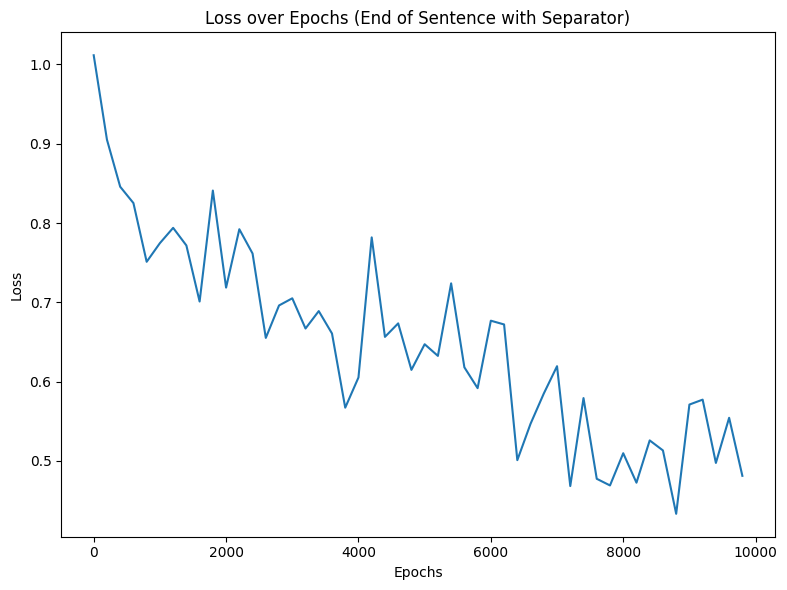

In [ ]:
plot_graphs(num_epochs, plot_interval, plot_avg_losses0, 'No Aspect Integration', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses1, 'Word Embedding + Aspect Embedding', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses2, 'Aspect Repeat with Separator', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses3, 'Aspect Repeat no Separator', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses4, 'End of Sentence with Separator', 'Loss')
plot_graphs(num_epochs, plot_interval, plot_avg_losses5, 'End of Sentence no Separator', 'Loss')

## Visualisation of Accuracy over Epochs

In [ ]:
plot_graphs(num_epochs, plot_interval, plot_accuracy0, 'No Aspect Integration', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy1, 'Word Embedding + Aspect Embedding', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy2, 'Aspect Repeat with Separator', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy3, 'Aspect Repeat no Separator', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy4, 'End of Sentence with Separator', 'Accuracy')
plot_graphs(num_epochs, plot_interval, plot_accuracy5, 'End of Sentence no Separator', 'Accuracy')

## Visualisation of Attention Weights

Original sentence: The food was good, but it's not worth the wait--or the lousy service.
Preprocessed sentence: ['food', 'good', 'but', 'not', 'worth', 'wait', 'lousy', 'service']


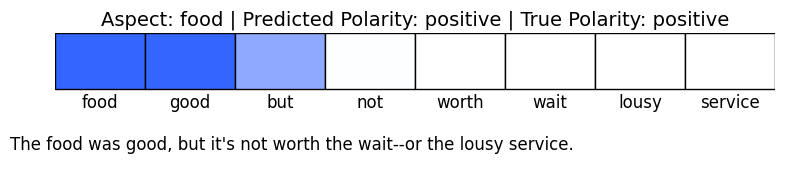

Original sentence: The food was good, but it's not worth the wait--or the lousy service.
Preprocessed sentence: ['food', 'good', 'but', 'not', 'worth', 'wait', 'lousy', 'service']


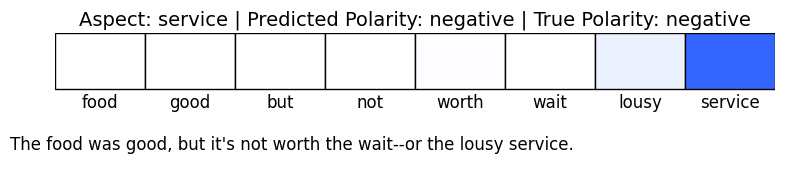

Original sentence: The ambience is stunning and the food is really good, but the portions are RIDICULOUSLY small.
Preprocessed sentence: ['ambience', 'stunning', 'food', 'good', 'but', 'portion', 'ridiculously', 'small']


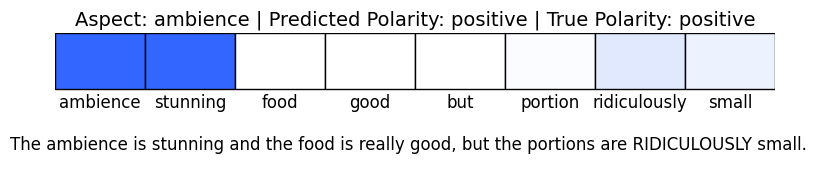

Original sentence: The ambience is stunning and the food is really good, but the portions are RIDICULOUSLY small.
Preprocessed sentence: ['ambience', 'stunning', 'food', 'good', 'but', 'portion', 'ridiculously', 'small']


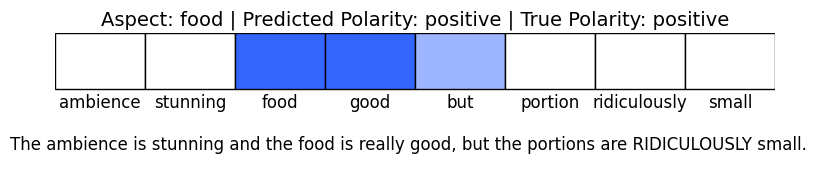

Original sentence: The ambience is stunning and the food is really good, but the portions are RIDICULOUSLY small.
Preprocessed sentence: ['ambience', 'stunning', 'food', 'good', 'but', 'portion', 'ridiculously', 'small']


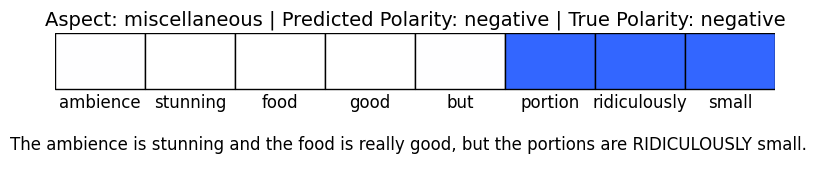

In [ ]:
# Function to visualise the attention weights for a sentence
def visualise_sentence(model, sentence, aspect, polarity, integration_type):
    pred_polarity, attention_weights, input_tensor = predict(model, sentence, aspect, integration_type)
    input_words = [idx_to_word[idx[0]] for idx in input_tensor.tolist()]
    attn_weights = attention_weights[0].tolist()[0][0][:len(input_words)]
    words, weights = get_words_weights(input_words, attn_weights, integration_type)
    print("Original sentence:", sentence)
    print("Preprocessed sentence:", preprocess_data([sentence])[0])
    plot_attention(words, weights, sentence, aspect, pred_polarity, polarity)

# Test sample instances
sentences = [test_x[2], test_x[3], test_x[528], test_x[529], test_x[530]]
aspects = [test_a[2], test_a[3], test_a[528], test_a[529], test_a[530]]
polarities = [test_y[2], test_y[3], test_y[528], test_y[529], test_y[530]]

# Visualise the attention weights for the sample instances
# Model 4: End of Sentence with Separator
for i in range(len(sentences)):
    visualise_sentence(model4, sentences[i], aspects[i], polarities[i], integration_type)